In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import networkx as nx
from queue import Queue

from typing import Optional, List,Tuple,Dict

C:\Users\Łukasz\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Phone Ranking Problem

Łukasz Andryszewski 151930

Choosing a new phone is often quite a daunting task, with many different models from different companies and varying prices.

In [2]:
data = pd.read_csv("./data/dataset.csv")
prefs = pd.read_csv("./data/preferences.csv")

In [3]:
data

,name,price-cost,ram-gain,screen-gain,disk-gain,oled-gain,os-gain,foldable-gain
0,Huawei P30,1699,6.000,6.10,128,1,3,0
1,Huawei P20 Lite,899,4.000,5.80,64,0,3,0
2,Iphone 15,4699,6.000,6.70,128,1,0,0
3,Iphone 12,2499,4.000,6.10,64,1,0,0
4,Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
5,Motorola Razr 40,2999,8.000,6.90,256,1,3,1
6,Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
7,Motorola Razr 8,2657,8.000,6.67,256,1,3,1
8,Nokia 2660 Flip,299,4.000,2.80,128,1,1,1
9,Huawei P40,1949,8.000,6.10,128,1,2,0


In [4]:
crit_types = [True if crit.split("-")[1]=="gain" else False for crit in data.drop(columns="name").columns ]
crit_types

[False, True, True, True, True, True, True]

In [5]:
data.columns = list(map(lambda s: s.split("-")[0],data.columns))
data

,name,price,ram,screen,disk,oled,os,foldable
0,Huawei P30,1699,6.000,6.10,128,1,3,0
1,Huawei P20 Lite,899,4.000,5.80,64,0,3,0
2,Iphone 15,4699,6.000,6.70,128,1,0,0
3,Iphone 12,2499,4.000,6.10,64,1,0,0
4,Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
5,Motorola Razr 40,2999,8.000,6.90,256,1,3,1
6,Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
7,Motorola Razr 8,2657,8.000,6.67,256,1,3,1
8,Nokia 2660 Flip,299,4.000,2.80,128,1,1,1
9,Huawei P40,1949,8.000,6.10,128,1,2,0


In [6]:
prefs

,id,preferred_to
0,0,1
1,4,6
2,8,11
3,3,2
4,3,9


In [7]:
def show_preferences(prefs,names,id_column="id",pref_column = "preferred_to"):
    for i,j in zip(prefs[id_column],prefs[pref_column]):
        print(f"{names[i]} is preferred to {names[j]}")

In [8]:
def verify_preferences(prefs,values,names,id_column="id",pref_column = "preferred_to"):
    for i,j in zip(prefs[id_column],prefs[pref_column]):
        if values[i] > values[j]: # for rankings
            print(f"{names[i]} is not preferred to {names[j]}!")

In [9]:
show_preferences(prefs,data["name"])

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40


#### 1. What is the domain of the problem about?
	
The problem involves constinst of various phones and some of their parameters.

#### 2. What is the source of the data?

The data is taken from the internet from various online shops that offer these phones. Some of their parameters were chosen and combined into this dataset.

#### 3. What is the point of view of the decision maker?

The decision maker is me and I value phones that have a reasonable price and are android. I also have a slight interest in foldable phones.

#### 4. What is the number of alternatives considered? Were there more of them in the original data set?
    
The number of alternatives is:

In [10]:
len(data)

15

There were not more of them in the dataset, as it was manually constructed. However the number of alternatives absolutely could have been greater.

#### 5. Describe one of the alternatives considered
   
   The first alternative is Huawei P30. Its price is 1699 and it is given in złotys. It has 6 GB of ram, a screen size of 6.1", a disk of 128 GB. It has an oled screen, an Android operating system and is not foldable. I currently own that phone.


#### 6. What is the number of criteria considered? Were there more of them in the original data set?

   The number of criteria considered is:

In [11]:
len(data.drop(columns="name").columns)

7

There were not more of them in the dataset. 

#### 7. What is the origin of the various criteria?
#### 8. What are the domains of the individual criteria?


##### Cost criteria
Price criteria comes from one of the various online offers for a given alternative. It is continous, its range is from 100 up to 5599. It is the only cost criterion

##### Gain criteria

Ram, screen and disk are some parameters of the phones. 

Ram is continuous - from 0.004 to 12

Screen is continuous - from 1.7 to 6.9

Disk is continuous - from 16 to 512

Oled and foldable are binary and describe if the phone has an oled screen and if it is foldable. Both of these features are desired.

OS is a criterion evaluated by the decision maker, which signifies which os the phone uses:

- 0 - Iphone
- 1 - Misc.
- 2 - Harmony OS
- 3 - Android

#### 9. Are all criteria of equal importance (should they have the same ”weights”)? If not, can the relative importance of the criteria under consideration be expressed in terms of weights? In this case, estimate the weights of each criterion on a scale of 1 to 10. Are there any criteria among the criteria that are completely or almost invalid / irrelevant?

The criteria are not of equal importance. Weights estimated by the decision maker:

In [12]:
estimated_weights = [9,4,2,3,5,8,6]

The least important criterion is probably the screen size, as most modern phones have very similar and reasonable screen sizes. In fact it the screen were too large, it might even be a negative (unless foldable). However the latter case does not appear in the dataset.

#### 10. Are there dominated alternatives among the considered data set?

In [61]:
def find_dominated_alternatives(data:pd.DataFrame,isGain:List[bool],domination=lambda a,b:not a>=b):

    a = len(data)
    nameless_data = data.drop(columns="name")
    
    dominates = [[] for _ in range(a)]

    for a_i in range(a):
        for a_j in range(a):
            if a_i == a_j:
                break

            i_dominates_j = True
            for g_j,g in enumerate(nameless_data):
                g_vals = np.array(data[g])

                if not isGain[g_j]:
                        
                    g_vals *= -1

                val_i = g_vals[a_i]
                val_j = g_vals[a_j]

                if domination(val_i,val_j):
                    i_dominates_j = False
                    break
        
            if i_dominates_j:
                dominates[a_i].append(a_j)

    return dominates

def show_domination(dominates,names,title="i dominates:",pref=">"):
    print(title)
    for i,dominated in enumerate(dominates):
        print(f"{names[i]} {pref} ",end="")
        print(*map(lambda j: names[j],dominated),sep=", ")


In [62]:
show_domination(find_dominated_alternatives(data,crit_types),data["name"])

i dominates:
Huawei P30 > 
Huawei P20 Lite > 
Iphone 15 > 
Iphone 12 > 
Motorola Razr Ultra > Iphone 15
Motorola Razr 40 > Iphone 15, Motorola Razr Ultra
Samsung Galaxy Z Flip 5 > 
Motorola Razr 8 > 
Nokia 2660 Flip > 
Huawei P40 > Iphone 12
Samsung Galaxy A55 > Iphone 12
Nokia 3310 > 
Samsung Galaxy M34 > Huawei P30, Iphone 12
Xiaomi Poco X6 Pro > Huawei P30, Iphone 12, Huawei P40, Samsung Galaxy A55
Lg V60 > Huawei P30, Iphone 15, Iphone 12


Looking at this, there is no Pareto Optimal solution.

#### 11. What should the theoretically best alternative look like in your opinion? Is it a small advantage on many criteria, or rather a strong advantage on few (but key) criteria? Which?

In my opinion it should be a criteria that is strong on few key criteria like price and os preferably with an oled screen and foldable.

#### 12. Which of the considered alternatives (provide name and values on individual criteria) seems to be the best / definitely better than the others? Is it determined by one reason (e.g. definitely the lowest price) or rather the overall value of the criteria? Does this alternative still have any weaknesses?

This is probably biased but the best alternative seems to be the Huawei P30. It is determined by its overall value on all criteria. Its major weakness is that its not foldable and also criteria which did not make it into the dataset.

#### 13. Which of the considered alternatives (provide name and values on individual criteria) seems to be the worst / definitely worse than the others? Is it determined by one reason (e.g. definitely the highest price), or rather the overall value of the criteria? Does this alternative still have any strengths?

Again a biased opinion, but Iphone 15 seems to be the worst. It is determined by its very high price and dislike towards iphones. It does not seem to have any great strengths.

In [16]:
def rank_string(ranking,names,third_column=None,third_name="id"):
	_str = f'{"rank":<5} | {"name":30} | {third_name:<5}\n'
	_str += len(_str)*"="
	_str += "\n"
	# for i,n in sorted(zip(ranking,names),key=lambda a:a[0]):
	for i,_id in enumerate(ranking):
		n = names[_id]
		_str += f"{i:<5} | {n:<30} | {_id if third_column is None else third_column[_id]:<5}\n"
	return _str

def show_rank(ranking,names):
	print(rank_string(ranking,names))

## SRF

In [17]:
def srf(rank:List[Optional[Tuple[str]]])->Dict[str,float]:
    """
        blank cards are none
    """

    n = len(rank)
    z = n-1
    blanks_below = rank.count(None)
    t = n-blanks_below
    r = []

    for i,elem in enumerate(rank):
        if elem is None:
            continue
        r.append(n-i)
    
    weights = np.array([1+((z-1)*((r_t-1)/(r[0]-1))) for r_t in r])

    criterions = filter(lambda a: not a is None,rank)
    mapping = {}
    for i,crits in enumerate(criterions):
        for crit in crits:
            mapping[crit] = weights[i]
    
    _sum = sum(mapping.values())
    mapping = dict([(k,v/_sum) for k,v in mapping.items()])

    return mapping

In [18]:
ranking = [
    ("price",),
    None,
    None,
    ("os",),
    ("foldable",),
    None,
    ("oled","screen"),
    ("ram","disk")]

In [19]:
crit_weights = srf(ranking)
print(crit_weights)
srf_weights = list(map(lambda c: crit_weights[c],data.drop(columns="name").columns))

{'price': 0.33793103448275863, 'os': 0.21379310344827587, 'foldable': 0.17241379310344826, 'oled': 0.0896551724137931, 'screen': 0.0896551724137931, 'ram': 0.04827586206896552, 'disk': 0.04827586206896552}


In [20]:
estimated_weights = np.array(estimated_weights)/np.sum(estimated_weights)
estimated_weights

array([0.24324324, 0.10810811, 0.05405405, 0.08108108, 0.13513514,
       0.21621622, 0.16216216])

In [21]:
np.array(crit_weights)

array({'price': 0.33793103448275863, 'os': 0.21379310344827587, 'foldable': 0.17241379310344826, 'oled': 0.0896551724137931, 'screen': 0.0896551724137931, 'ram': 0.04827586206896552, 'disk': 0.04827586206896552},
      dtype=object)

The weights gained from the SRF method are not far off from the estimated weights and it just comes down to tweaking the preferencial informations.

## PROMETHEE

In [22]:
def type_1(d):
	return 1 if d > 0 else 0

def type_5(d,q:float,p:float):
	if d > p:
		return 1
	elif d <= q:
		return 0
	else: 
		return (d-q)/(p-q)

In [23]:
class Promethee:
	def __init__(self,data:pd.DataFrame,criterion_type:Tuple[bool],criterion_weights:Tuple[float]=None,discrimination_thresholds:np.array=None):
		self.data = data.drop(columns="name")
		self.names = data["name"]
		self.ranking = [i for i in range(len(self.names))]
		self.is_crit_gain = criterion_type
		self.criterion_weighs = criterion_weights
		self.criterion_funcs = self._init_crit_funcs(discrimination_thresholds)

	def _init_crit_funcs(self,disc_thresh):
		output=[]
		for i,(p,q) in enumerate(disc_thresh):
			output.append((lambda qi,pi: lambda a,b: type_5(a-b,qi,pi))(q,p) if self.is_crit_gain[i] else (lambda qi,pi: lambda a,b: type_5(b-a,qi,pi))(q,p))
		return output
		

	def _cp_index(self,data:pd.DataFrame,criterion_weights:List[float]=None,criterion_func:List[callable]=None)->np.array:

		n = len(data)
		matrix = np.zeros((n,n))

		if criterion_weights==None:
			criterion_weights = [1 for _ in data.columns]

		if criterion_func == None:
			criterion_func = [type_1 for _ in criterion_weights]

		for c,criterion in enumerate(data.columns):
			for i,a in enumerate(data[criterion]):
				for j,b in enumerate(data[criterion][i+1:],i+1):
					pi = criterion_func[c]
					w = criterion_weights[c]
					matrix[i][j] += w * pi(a,b)
					matrix[j][i] += w * pi(b,a)
		
		return matrix/sum(criterion_weights)
	
	def _flow(self,cpi:np.array):
		positive_flow = np.sum(cpi,axis=1)
		negative_flow = np.sum(cpi,axis=0)

		return positive_flow,negative_flow
	
	def _flip_rank(self,rank):
		flipped = [None for id in rank]
		for r,id in enumerate(rank):
			flipped[id] = r
		return flipped

	def flipped_ranking(self):
		return self._flip_rank(self.ranking)

	def __str__(self):
		return rank_string(self.ranking,self.names)

In [24]:
class Promethee1(Promethee):
	def rank(self):
		cpi = self._cp_index(self.data,self.criterion_weighs,self.criterion_funcs)
		self.pos_flow,self.neg_flow = self._flow(cpi)

		self.pos_rank = np.argsort(-self.pos_flow)
		self.neg_rank = np.argsort(self.neg_flow)

		pos_pref_matrix = self._pref_from_ranking(self.pos_rank)
		neg_pref_matrix = self._pref_from_ranking(self.neg_rank)

		combined_matrix = np.logical_and(pos_pref_matrix,neg_pref_matrix).astype(np.uint8)

		self._simplify_ranking(combined_matrix)
		
		self._show_ranking(combined_matrix)

		return self.ranking
	
	def _show_ranking(self,matrix):
		g = nx.DiGraph(matrix)
		pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
		plt.figure(figsize=(10,10))
		nx.draw(g,pos,with_labels=False)
		custom_labels = self.names
		nx.draw_networkx_labels(g, pos, labels=custom_labels, font_size=12, font_color='black')

	def _simplify_ranking(self,matrix):
		#for i, row in enumerate(matrix):
		for i in range(len(matrix)):
			matrix = self._remove_transient_connections(matrix,i)
			
			

	def _remove_transient_connections(self,matrix,start):
		#bfs 
		q = Queue()
		q.put(start)
		isQueued = [False for _ in matrix]
		while not q.empty():
			i = q.get()
			#neighbours = np.where(matrix[i]==1)
			row = matrix[i]
			for j,n in enumerate(row):
				if n == 0: continue

				if i != start and matrix[start,j] == 1:
					matrix[start,j] = 0

				#if isQueued[j]
				q.put(j)

		return matrix
	

	def _pref_from_ranking(self,ranking):
		a = len(self.data)
		pref_matrix = np.zeros((a,a))	

		for r_i,i in enumerate(ranking):
			for r_j,j in enumerate(ranking[r_i+1:],r_i):
				pref_matrix[i][j] = 1

		return pref_matrix


	def __str__(self):
		return f"Positive flow ranking:\n{self.positive_ranking()}\nNegative flow ranking:\n{self.negative_ranking()}"
	
	def positive_ranking(self):
		return rank_string(self.pos_rank,self.names)
	def negative_ranking(self):
		return rank_string(self.neg_rank,self.names)

	def _pref_check(self,i,j):
		return self.pos_flow[i] >= self.pos_flow[j] and self.neg_flow[i] <= self.neg_flow[j]
	def _equal_check(self,i,j):
		return (np.allclose(self.pos_flow[i],self.pos_flow[j]) and np.allclose(self.neg_flow[i],self.neg_flow[j]))
	def _incomparable(self,i,j):
		return ((self.pos_flow[i] > self.pos_flow[j] and self.neg_flow[i] > self.neg_flow[j]) or 
				(self.pos_flow[i] < self.pos_flow[j] and self.neg_flow[i] < self.neg_flow[j]))

In [25]:
class Promethee2(Promethee):
	def rank(self):
		self.cpi = self._cp_index(self.data,self.criterion_weighs,self.criterion_funcs)
		pos_flow,neg_flow = self._flow(self.cpi)

		self.f = pos_flow-neg_flow

		self.ranking = np.argsort(-self.f)

		return self.ranking

Preferential information used for PROMETHEE I and II.

In [26]:
crit_discrimination = [
    #p,q
	[500,100],
	[4,2],
	[0.5,0.1],
	[64,16],
	[0,0],
	[2,0],
	[0,0]
]

The final ranking created by PROMETHEE I.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

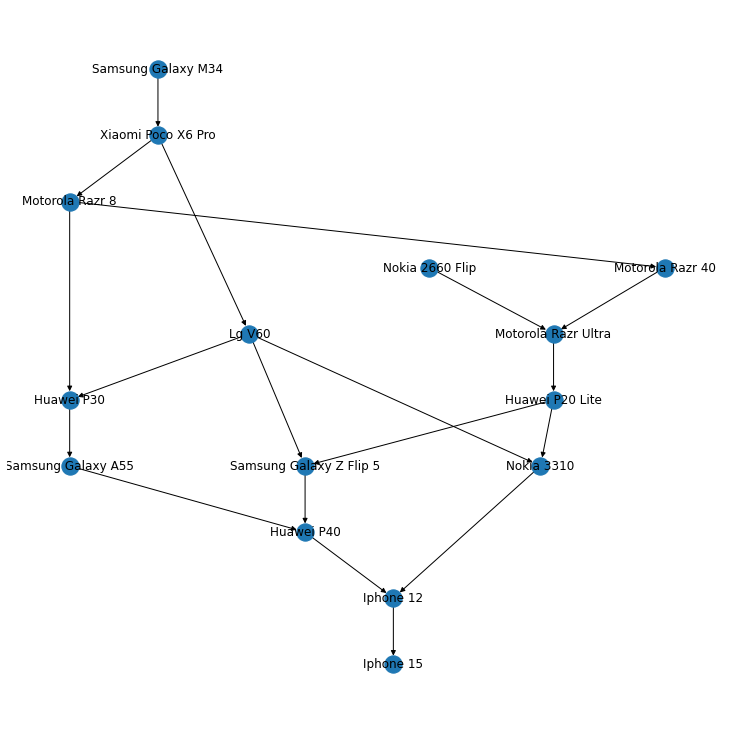

In [27]:
prom1ranker = Promethee1(data,crit_types,srf_weights,crit_discrimination)
prom1ranker.rank()

The positive flow ranking achieved by PROMETHEE I.

In [28]:
print(prom1ranker.positive_ranking())

rank  | name                           | id   
0     | Nokia 2660 Flip                | 8    
1     | Samsung Galaxy M34             | 12   
2     | Xiaomi Poco X6 Pro             | 13   
3     | Motorola Razr 8                | 7    
4     | Motorola Razr 40               | 5    
5     | Motorola Razr Ultra            | 4    
6     | Huawei P20 Lite                | 1    
7     | Lg V60                         | 14   
8     | Nokia 3310                     | 11   
9     | Samsung Galaxy Z Flip 5        | 6    
10    | Huawei P30                     | 0    
11    | Samsung Galaxy A55             | 10   
12    | Huawei P40                     | 9    
13    | Iphone 12                      | 3    
14    | Iphone 15                      | 2    



In [29]:
verify_preferences(prefs,prom1ranker._flip_rank(prom1ranker.pos_rank),data["name"])

Huawei P30 is not preferred to Huawei P20 Lite!
Iphone 12 is not preferred to Huawei P40!


The negative flow ranking achieved by PROMETHEE I.

In [30]:
print(prom1ranker.negative_ranking())

rank  | name                           | id   
0     | Samsung Galaxy M34             | 12   
1     | Xiaomi Poco X6 Pro             | 13   
2     | Lg V60                         | 14   
3     | Motorola Razr 8                | 7    
4     | Huawei P30                     | 0    
5     | Samsung Galaxy A55             | 10   
6     | Motorola Razr 40               | 5    
7     | Nokia 2660 Flip                | 8    
8     | Motorola Razr Ultra            | 4    
9     | Huawei P20 Lite                | 1    
10    | Samsung Galaxy Z Flip 5        | 6    
11    | Huawei P40                     | 9    
12    | Nokia 3310                     | 11   
13    | Iphone 12                      | 3    
14    | Iphone 15                      | 2    



In [31]:
verify_preferences(prefs,prom1ranker._flip_rank(prom1ranker.neg_rank),data["name"])

Iphone 12 is not preferred to Huawei P40!


Ranking achieved by PROMETHEE II.

In [32]:
prom2ranker = Promethee2(data,crit_types,srf_weights,crit_discrimination)
prom2ranker.rank()
print(str(prom2ranker))


rank  | name                           | id   
0     | Samsung Galaxy M34             | 12   
1     | Xiaomi Poco X6 Pro             | 13   
2     | Nokia 2660 Flip                | 8    
3     | Lg V60                         | 14   
4     | Motorola Razr 8                | 7    
5     | Motorola Razr 40               | 5    
6     | Motorola Razr Ultra            | 4    
7     | Huawei P30                     | 0    
8     | Samsung Galaxy A55             | 10   
9     | Huawei P20 Lite                | 1    
10    | Samsung Galaxy Z Flip 5        | 6    
11    | Huawei P40                     | 9    
12    | Nokia 3310                     | 11   
13    | Iphone 12                      | 3    
14    | Iphone 15                      | 2    



In [33]:
verify_preferences(prefs,prom2ranker.flipped_ranking(),data["name"])

Iphone 12 is not preferred to Huawei P40!


In no ranking is Iphone 12 preferred to Huawei P40 as it is stated in the preferences dataset. Comparing the two alternatives reveals that it might be just a contradiction for Iphone 12 to be preferred over Huawei P40.

The Huawei P30 is not indicated to be the best. My preference towards it is just bias and it is quite a dated phone.

The Iphone 15 was inticated the be the worst in every ranking, which was a bit expected.

## ELECTRE-TRI-B

In [76]:
class ElectreTriB:
	def __init__(self,data:pd.DataFrame,criterion_type:list[bool],criterion_weights:list[float],class_profiles:np.array, pref_indif_veto:np.array):
		"""
			class_profiles should be (criterion x profiles)

			pref_indif_veto should be(criterion x profiles x 3)
		"""
		self.data = data.drop(columns="name")
		self.names = data["name"]
		self.is_crit_gain = criterion_type
		self.class_profiles = class_profiles
		self.pref_indif_veto = pref_indif_veto
		self.weights = criterion_weights

		self.b = self.class_profiles.shape[1]
		self.c = self.b
		self.g = len(self.data.columns)
		self.a = len(self.data)

	def _marginals(self,thresholds,isConc=True,isInverse=False):
		matrix = np.zeros((self.g,self.b,self.a)) if not isInverse else np.zeros((self.g,self.a,self.b))

		for g_i,g in enumerate(self.data.columns):
			for a_i in range(self.a):
				for b_j in range(self.b):

					# for gain criterion
					d = self.class_profiles[g_i][b_j]-self.data[g][a_i]
					
					# invert for cost
					if not self.is_crit_gain[g_i]:
						d *= -1

					# invert for profile first, alternative second
					if isInverse:
						d *= -1

					qv,p = thresholds[g_i][b_j],self.pref_indif_veto[g_i][b_j][0]
					out = 0

					# count concordance or discordance
					if isConc:
						out = self._conc(d,qv,p)
					else:
						out = self._disc(d,qv,p)

					if not isInverse:
						matrix[g_i][b_j][a_i] = out
					else:
						matrix[g_i][a_i][b_j] = out

		return matrix

	def _marginal_concordance(self):
		self.mconc = self._marginals(self.pref_indif_veto[:,:,1])
	def _inv_m_conc(self):
		self.invmconc = self._marginals(self.pref_indif_veto[:,:,1],isInverse=True)

	def _marginal_discordance(self):
		self.mdisc = self._marginals(self.pref_indif_veto[:,:,2],isConc=False)
	def _inv_m_disc(self):
		self.invmdisc = self._marginals(self.pref_indif_veto[:,:,2],isConc=False,isInverse=True)

	def _conc(self,d,q,p):
		if d >= p:
			return 0
		elif d <= q:
			return 1 
		else:
			return (p-d)/(p-q)
	
	def _disc(self,d,v,p):
		if d <= p:
			return 0
		elif d >= v:
			return 1
		else:
			return (d-p)/(v-p)

	def _comprehensive_concordance(self,mconc):
		return np.sum((np.array(self.weights)*mconc.T).T,axis=0)/np.sum(self.weights)


	def _outranking_credibility(self):
		self.out_cred = np.zeros((self.a,self.b))
		self.inv_out_cred = np.zeros((self.b,self.a))

		for a_i in range(self.a):
			for b_j in range(self.b):
				_C = self.cconc[b_j][a_i]
				_invC = self.invcconc[a_i][b_j]

				f = [f_j for f_j in self.mdisc[:,b_j,a_i] if f_j > _C]
				invf = [f_j for f_j in self.invmdisc[:,a_i,b_j] if f_j > _invC]
				
				prod = np.prod([(1-f_j)/(1-_C) for f_j in f])
				invprod = np.prod([(1-f_j)/(1-_invC) for f_j in invf])

				self.out_cred[a_i][b_j] = _C * prod
				self.inv_out_cred[b_j][a_i] = _invC * invprod

	def class_assignment(self,cred_threshold,isPessimistic=True):
		self.run()

		classes = np.zeros(self.a,dtype=np.int16) if isPessimistic else np.full(self.a,self.c-1)

		for a_i in range(self.a):
			for b_j in range(self.b):
				# start from best for pessimistic
				if isPessimistic: b_j = self.b - b_j - 1

				
				if isPessimistic and self._pessimistic_ev(a_i,b_j,cred_threshold):
					b_j += 1
					break

				if (not isPessimistic) and self._optimistic_ev(a_i,b_j,cred_threshold):
					break
			classes[a_i]=(max(min(b_j,self.c-1),0))
		
		return classes

	def _pessimistic_ev(self,a,b,thresh):
		return self.out_cred[a][b] >= thresh# and self.inv_out_cred[b][a] < thresh
	
	def _optimistic_ev(self,a,b,thresh):
		return self.out_cred[a][b] < thresh and self.inv_out_cred[b][a] >= thresh

	def show_assignments(self,thresh):
		print("Optimistic class assignment:")
		self.optimistic = self.class_assignment(thresh,isPessimistic=False)
		default_rank = [i for i in range(self.a)]
		print(rank_string(default_rank,self.names,self.optimistic,"class"))
		print("Pessimistic class assignment:")
		self.pessimistic=self.class_assignment(thresh,isPessimistic=True)
		print(rank_string(default_rank,self.names,self.pessimistic,"class"))

	def run(self):
		self._marginal_concordance()
		self._inv_m_conc()
		self._marginal_discordance()
		self._inv_m_disc()
		self.cconc = self._comprehensive_concordance(self.mconc)
		self.invcconc = self._comprehensive_concordance(self.invmconc)
		self._outranking_credibility()

Preferential information for Electre Tri-B. Class profiles describes 5 profiles for 5 decision classes. Preferences, indifferences and vetoes describe thresholds for according classes.

In [43]:
class_profiles = np.array([
	[5000,0.5,1,5,0,0,0],
	[3700,1,2,10,0,1,0],
	[2500,3,4.5,100,1,2,1],
	[1000,7,5.9,350,1,3,1],
	[500,16,7,640,1,3,1]
]).T

preferences = [
	[1000,1000,1000,1000,1000],
	[0.1,0.3,2,4,4],
	[3,0.5,0.5,0.2,0.2],
	[3,4,16,32,32],
	[1,1,0,0,0],
	[3,2,1,0,0],
	[1,1,1,0,0]
]

indifferences = [
	[100,100,150,200,500],
	[0.01,0.1,1,1,2],
	[1,0.3,0.25,0.1,0.1],
	[1,2,8,16,16],
	[0,0,0,0,0],
	[1,1,0,0,0],
	[0,0,0,0,0]
]

vetoes = [
	[1000,1000,1000,1000,2000],
	[0.2,0.5,8,16,16],
	[6,1,1,0.5,0.5],
	[8,16,32,64,64],
	[2,2,0.5,0.5,0.5],
	[2,2,1,1,1],
	[2,2,2,2,2]
]

pref_indif_vetoes = np.stack([preferences,indifferences,vetoes],axis=2)

The outranking threshold was chosen to be 0.55, based on the weights achieved using SRF procedure. The profiles and veto thresholds were adjusted a couple of times to allow reaching some alternatives higher classes.

In [80]:
outranking_threshold = np.sum(np.sort(srf_weights)[-2:])
outranking_threshold

0.5517241379310345

In [91]:
electre = ElectreTriB(data,crit_types,srf_weights,class_profiles,pref_indif_vetoes)
electre.run()

In [92]:
electre.out_cred

array([[1.        , 1.        , 0.73793103, 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.66244444, 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.92527969, 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.77159432, 0.        , 0.        ],
       [0.81263602, 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.90756187, 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.73793103, 0.        , 0.        ],
       [1.        , 1.        , 0.73793103, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.73793103, 0.        , 0.        ],
       [1.        , 1.        , 0.73793103, 0.22817667, 0.        ],
       [1.        , 1.        , 0.

In [97]:
electre.inv_out_cred.T

array([[0.        , 0.        , 0.        , 0.60689655, 0.69655172],
       [0.        , 0.        , 0.        , 0.7862069 , 0.7862069 ],
       [0.        , 0.        , 0.        , 0.        , 0.91034483],
       [0.        , 0.        , 0.        , 0.82068966, 0.91034483],
       [0.        , 0.        , 0.        , 0.        , 0.52413793],
       [0.        , 0.        , 0.        , 0.        , 0.52413793],
       [0.        , 0.        , 0.        , 0.        , 0.52413793],
       [0.        , 0.        , 0.        , 0.        , 0.52413793],
       [0.        , 0.        , 0.        , 0.52630172, 0.73793103],
       [0.        , 0.        , 0.        , 0.82068966, 0.91034483],
       [0.        , 0.        , 0.        , 0.        , 0.69655172],
       [0.        , 0.        , 0.        , 0.70431034, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.69655172],
       [0.        , 0.        , 0.        , 0.        , 0.69655172],
       [0.        , 0.        , 0.

When it comes to outranking, there seems to be a like a border between class 2 and class 3. There outranking credibility falls and inverse outranking credibility starts rising.

In [94]:
electre.show_assignments(outranking_threshold)

Optimistic class assignment:
rank  | name                           | class
0     | Huawei P30                     | 3    
1     | Huawei P20 Lite                | 3    
2     | Iphone 15                      | 4    
3     | Iphone 12                      | 3    
4     | Motorola Razr Ultra            | 4    
5     | Motorola Razr 40               | 4    
6     | Samsung Galaxy Z Flip 5        | 4    
7     | Motorola Razr 8                | 4    
8     | Nokia 2660 Flip                | 4    
9     | Huawei P40                     | 3    
10    | Samsung Galaxy A55             | 4    
11    | Nokia 3310                     | 3    
12    | Samsung Galaxy M34             | 4    
13    | Xiaomi Poco X6 Pro             | 4    
14    | Lg V60                         | 4    

Pessimistic class assignment:
rank  | name                           | class
0     | Huawei P30                     | 3    
1     | Huawei P20 Lite                | 2    
2     | Iphone 15                      | 2    


For some of the alternatives the pessimistic and optimistic assignment are the same. The most notable is that for all alternatives the optimistic assignment gives at worst class 3.

Running the ELECTRE Tri-B with the previously estimated weights. The outranking threshold was estimated from the 3 most important critetrion, because otherwise it would be less than 0.5.

In [82]:
outranking_threshold2 = sum(np.sort(estimated_weights)[-3:])
outranking_threshold2

0.6216216216216217

In [102]:
electre2 = ElectreTriB(data,crit_types,estimated_weights,class_profiles,pref_indif_vetoes)
electre2.run()

In [103]:
electre2.out_cred

array([[1.        , 1.        , 0.7027027 , 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.75702703, 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.94621622, 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.76499205, 0.        , 0.        ],
       [0.86513514, 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.86286169, 0.        , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.7027027 , 0.        , 0.        ],
       [1.        , 1.        , 0.7027027 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.7027027 , 0.        , 0.        ],
       [1.        , 1.        , 0.7027027 , 0.25161241, 0.        ],
       [1.        , 1.        , 0.

In [105]:
electre2.inv_out_cred.T

array([[0.        , 0.        , 0.        , 0.59459459, 0.64864865],
       [0.        , 0.        , 0.        , 0.78378378, 0.78378378],
       [0.        , 0.        , 0.        , 0.        , 0.86486486],
       [0.        , 0.        , 0.        , 0.81081081, 0.86486486],
       [0.        , 0.        , 0.        , 0.        , 0.48648649],
       [0.        , 0.        , 0.        , 0.        , 0.48648649],
       [0.        , 0.        , 0.        , 0.        , 0.48648649],
       [0.        , 0.        , 0.        , 0.        , 0.48648649],
       [0.        , 0.        , 0.        , 0.55037162, 0.7027027 ],
       [0.        , 0.        , 0.        , 0.81081081, 0.86486486],
       [0.        , 0.        , 0.        , 0.        , 0.64864865],
       [0.        , 0.        , 0.        , 0.78716216, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.64864865],
       [0.        , 0.        , 0.        , 0.        , 0.64864865],
       [0.        , 0.        , 0.

In [107]:
electre2.show_assignments(outranking_threshold)

Optimistic class assignment:
rank  | name                           | class
0     | Huawei P30                     | 3    
1     | Huawei P20 Lite                | 3    
2     | Iphone 15                      | 4    
3     | Iphone 12                      | 3    
4     | Motorola Razr Ultra            | 4    
5     | Motorola Razr 40               | 4    
6     | Samsung Galaxy Z Flip 5        | 4    
7     | Motorola Razr 8                | 4    
8     | Nokia 2660 Flip                | 4    
9     | Huawei P40                     | 3    
10    | Samsung Galaxy A55             | 4    
11    | Nokia 3310                     | 3    
12    | Samsung Galaxy M34             | 4    
13    | Xiaomi Poco X6 Pro             | 4    
14    | Lg V60                         | 4    

Pessimistic class assignment:
rank  | name                           | class
0     | Huawei P30                     | 3    
1     | Huawei P20 Lite                | 2    
2     | Iphone 15                      | 2    


As there is no substantial difference between the weights, the results are the same.

In [90]:
print("Optimistic: ")
verify_preferences(prefs,-electre.optimistic,data["name"])
print()
print("Pessimistic: ")
verify_preferences(prefs,-electre.pessimistic,data["name"])

Optimistic: 
Iphone 12 is not preferred to Iphone 15!

Pessimistic: 
Iphone 12 is not preferred to Huawei P40!


Iphone 15 has a higher class assignment in the optimistic case, as it does have better qualities than it. Falling flat only on price. Again Huawei P40 is rated higher than Iphone 12, however it does seem to be an inconsistency in the a priori preferences.

Huawei P30 did get into a high class, however not the best one.

Iphone 15 was indicated to be either class 2 or 4, which could be because it has solid features but is kept down by its os and price.